In [6]:
import sys
import socket

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    sys.path.extend(['/home/jorg/repository/seg_eval_pipeline'])
else:
    sys.path.extend(['/home/jorg/repo/seg_eval_pipeline'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm
import numpy as np
import torch

from config.dcnn.general_setup import base_config as dcnn_config

from io_tools.acdc.data_handler_phase import ACDCDataHandlerPhase
from plotting.seg_errors_and_maps import plot_slices, plot_slices_per_phase

from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from plotting.color_maps import transparent_cmap

mycmap = transparent_cmap(cm.jet)


%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ready


In [2]:
fold_id = 0
data_handler = ACDCDataHandlerPhase(dcnn_config, loss_function="brier")
# data_handler.detector_dataset(fold_id=fold_id, mc_dropout=False)
data_handler.get_acdc_images_labels(fold_id=fold_id, load_ref_labels=True)
# data_handler.get_test_set(fold_id=0, patient_id=None)

Loading test dataset:   4%|▍         | 1/25 [00:00<00:04,  5.00it/s]/home/jorg/anaconda2/envs/pyt_1_0_0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Using SeparatePhaseVolume: 100%|██████████| 25/25 [00:00<00:00, 39257.81it/s]


# Interactive image viewer 
### requires ACDCDataHandlerPhase

In [8]:
def show_overlay(data_handler, type_overlay, myaxis, patient_id, cardiac_phase, sliceid, mc_dropout=False):
    if type_overlay == "ref":
        ref_labels = data_handler.get_label(patient_id, cardiac_phase)
        ref_labels = np.argmax(ref_labels, axis=0)
        myaxis.imshow(ref_labels[... ,sliceid -1], cmap=mycmap)
    if type_overlay == "error":
        errors_binary = data_handler.get_pred_labels_errors(patient_id, cardiac_phase,
                                                            mc_dropout=mc_dropout, force_reload=True)
        errors = np.argmax(errors_binary[..., sliceid -1], axis=0)
        myaxis.imshow(errors,  cmap=mycmap)
    if type_overlay == "emap":
        emap = data_handler.get_entropy_maps(patient_id, cardiac_phase)
        myaxis.imshow(emap[:, :, sliceid -1],  cmap=mycmap)
    if type_overlay == "umap":
        umap = data_handler.get_bayes_umap(patient_id, cardiac_phase)
        myaxis.imshow(umap[:, :, sliceid -1],  cmap=mycmap)


def im_viewer(patient_id, sliceid=0, type_overlay=None, mc_dropout=False):
    
    plt.rcParams['figure.figsize'] = [16.0, 16.0]
    ax = plt.gca()
    rows = 2
    columns = 4
    mri_image_ed = data_handler.get_image(patient_id, "ED")
    num_slices =mri_image_ed.shape[2]
    mri_image_es = data_handler.get_image(patient_id, "ES")
    if sliceid <= num_slices:
        cardiac_phase = "ED"
        ax1 = plt.subplot2grid((rows, columns), (0, 0), rowspan=2, colspan=2)
        mri_slice_ed = mri_image_ed[..., sliceid - 1]
        mri_slice_ed = mri_slice_ed[dcnn_config.pad_size:-dcnn_config.pad_size,
                       dcnn_config.pad_size:-dcnn_config.pad_size]
        ax1.imshow(mri_slice_ed, cmap='gray')
        show_overlay(data_handler, type_overlay, ax1, patient_id, cardiac_phase, sliceid, mc_dropout)
        ax1.set_title("ED", **dcnn_config.title_font_small)
        plt.axis("off")

        ax2 = plt.subplot2grid((rows, columns), (0, 2), rowspan=2, colspan=2)
        cardiac_phase = "ES"
        mri_slice_es = mri_image_es[..., sliceid - 1]
        mri_slice_es = mri_slice_es[dcnn_config.pad_size:-dcnn_config.pad_size,
                       dcnn_config.pad_size:-dcnn_config.pad_size]
        ax2.imshow(mri_slice_es, cmap='gray')
        show_overlay(data_handler, type_overlay, ax2, patient_id, cardiac_phase, sliceid, mc_dropout)
        ax2.set_title("ES {}/{}".format(sliceid, num_slices), **dcnn_config.title_font_small)
        plt.axis("off")


In [9]:
max_patid=len(data_handler.images)

silence = interact(im_viewer, patient_id=list(data_handler.images.keys()),
                    sliceid=widgets.IntSlider(min=1,max=20,step=1),
                   mc_dropout=True,
                   type_overlay=["error", "ref", "emap", "umap", None])

interactive(children=(Dropdown(description='patient_id', options=('patient016', 'patient017', 'patient018', 'p…

99127


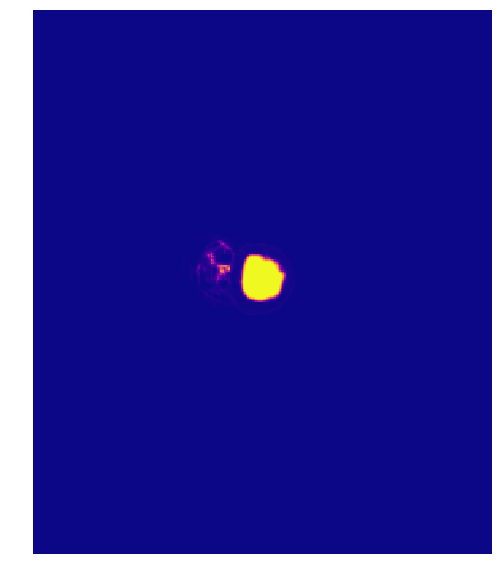

In [17]:
patient_id = "patient037"

slice_id = 3
cardiac_phase = 1
cls_idx = 3

pred_probs = data_handler.get_pred_probs(patient_id=patient_id, cardiac_phase=cardiac_phase,
                                         mc_dropout=False, force_reload=True)
# fname = "/home/jorg/repository/dcnn_acdc/data/Folds/fold0/brier/pred_lbls/patient016_pred_probs_mc.npz"
# data = np.load(fname)
# pred_probs = data['pred_probs']
pred_prob_slice = pred_probs[cls_idx, :, :, slice_id]
print(np.count_nonzero(pred_prob_slice))
plt.rcParams['figure.figsize'] = [12.0, 10.0]
plt.imshow(pred_prob_slice, cmap=plt.get_cmap('plasma'))
plt.axis('off')
plt.show()


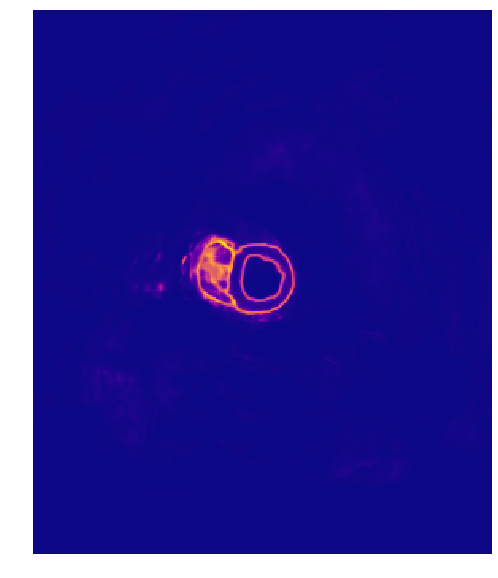

In [24]:
emap = data_handler.get_entropy_maps(patient_id=patient_id, cardiac_phase=cardiac_phase, force_reload=True)
# umap = data_handler.get_bayes_umap(patient_id=patient_id, force_reload=True)
plt.rcParams['figure.figsize'] = [12.0, 10.0]


unc_map_slice = emap[:, :, slice_id]
plt.imshow(unc_map_slice, cmap=plt.get_cmap('plasma'))
plt.axis('off')
plt.show()

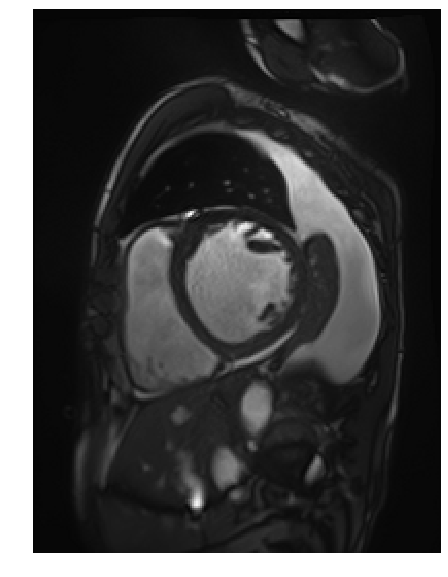

In [25]:
from utils.common import convert_to_multiclass
from plotting.color_maps import SegColorMap

seg_map = SegColorMap()
slice_id = 2

pred_labels = data_handler.get_pred_labels(patient_id=patient_id, mc_dropout=False, force_reload=True)
mri_image = data_handler.images[patient_id]

plt.rcParams['figure.figsize'] = [12.0, 10.0]
pred_label_slice = pred_labels[:, :, :, slice_id]

pred_label_slice = convert_to_multiclass(pred_label_slice[:4])
pred_label_slice = np.swapaxes(pred_label_slice, 0, 1).astype(np.int)

pred_label_slice = seg_map.convert_multi_labels(pred_label_slice)
mri_slice = np.swapaxes(mri_image[1, :, :, slice_id], 0, 1)

#pred_label_slice = (pred_label_slice - np.min(pred_label_slice)) / (np.max(pred_label_slice) - np.min(pred_label_slice)) * 255
plt.imshow(mri_slice, cmap=cm.gray)
# plt.imshow(pred_label_slice, cmap=seg_map.cmap)
plt.axis('off')
plt.show()

# Visualize volumes per phase

### Alternative to interactive image viewer (see above)

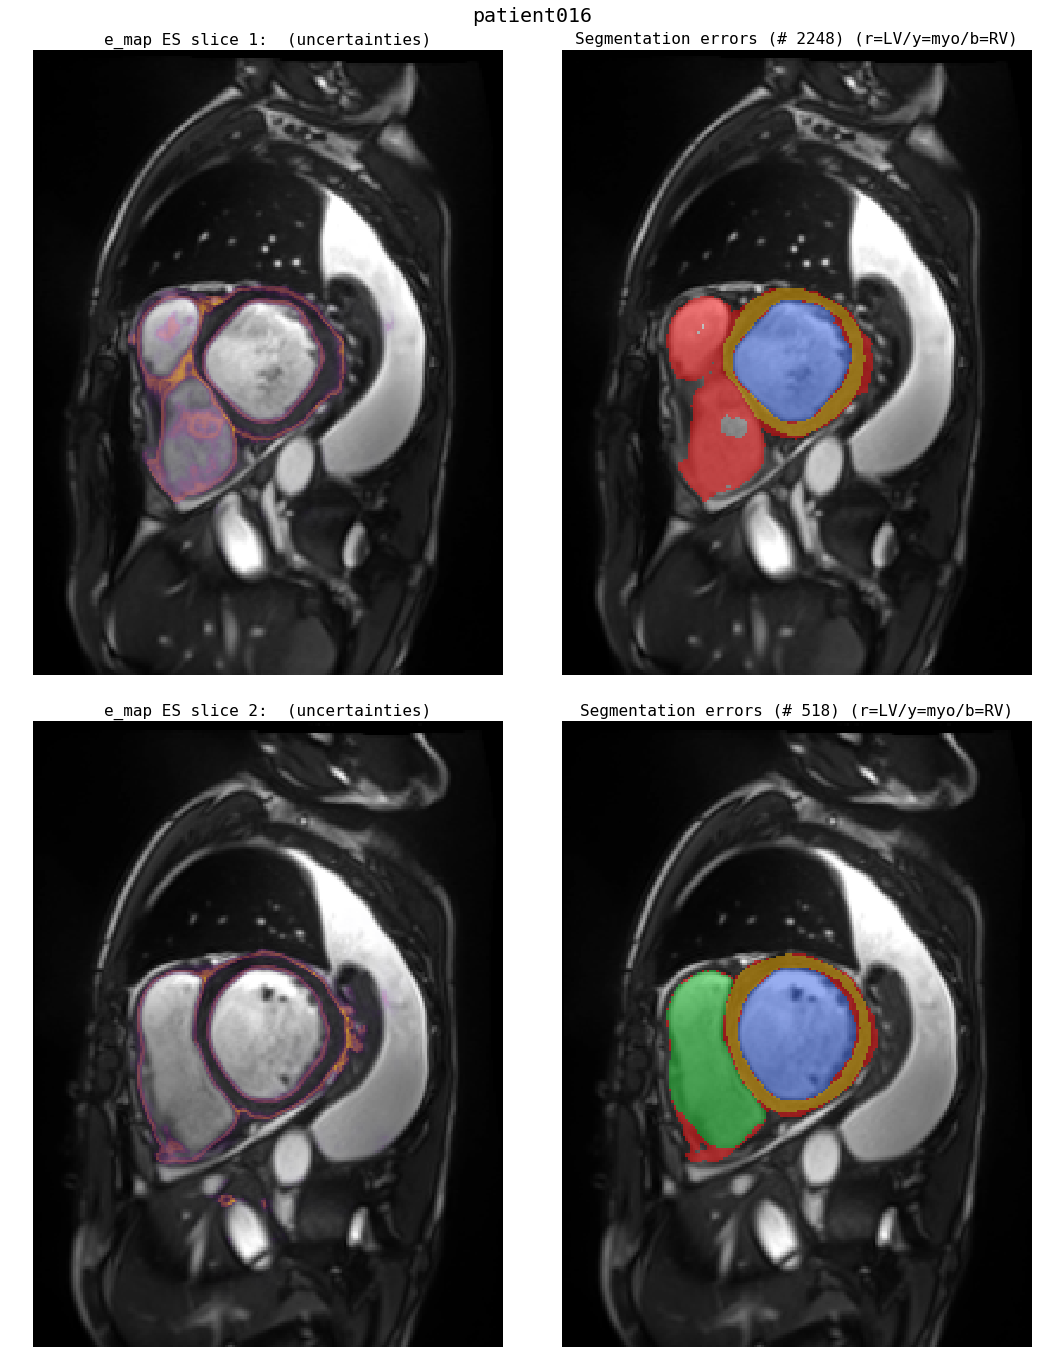

In [14]:
patient_id = "patient016"

# right column: "ref", "error", "auto", "heat_map", "map", "error_roi"
# left column: "ref", "error", "auto", "heat_map", "map", "error_roi"

plot_slices_per_phase(data_handler, patient_id, do_show=True, do_save=False, rd_model_name=None,
                     left_column_overlay="map", alpha=0.5, cardiac_phase="ES",
                     slice_range=[0, 2], type_of_map="e_map", aggregate_func=None, 
                     right_column_overlay="error")


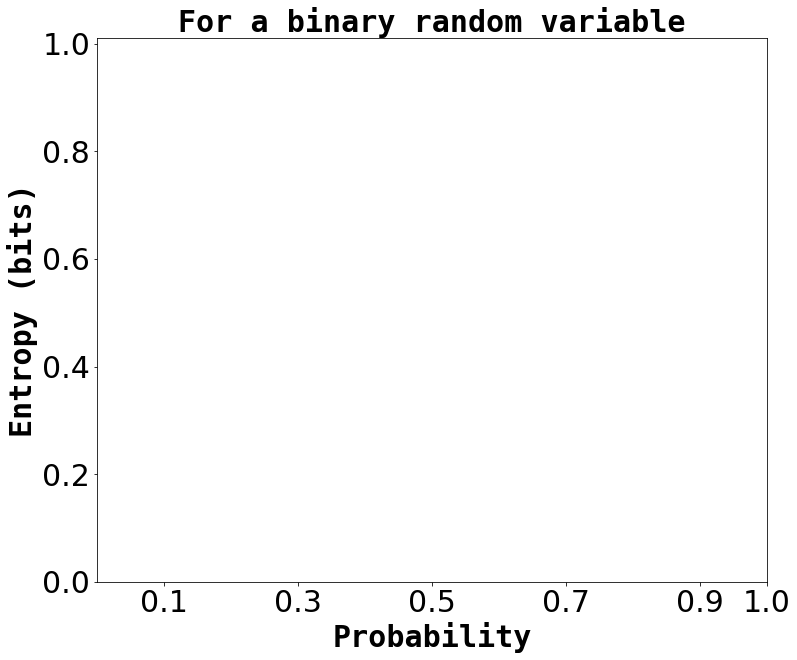

In [35]:
from plotting.entropy_function import plot_binary_entropy

plot_binary_entropy()



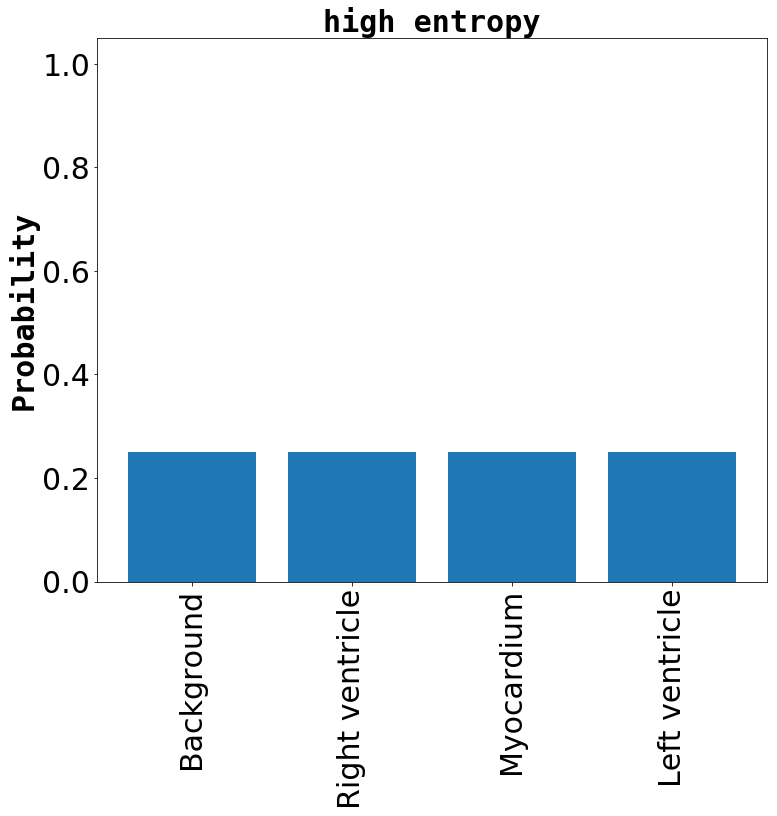

In [43]:
from plotting.entropy_function import plot_entropy_hist

plot_entropy_hist(entropy_type="high")
